In [1]:
%matplotlib inline

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, RANSACRegressor, LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, RocCurveDisplay, precision_score, recall_score, f1_score
# from nose.tools import *
# Write your imports in the cell below

In [37]:
def assert_is_not_none(value, error_message="Value cannot be None"):
  if value is None:
    raise AssertionError(error_message)
  
def assert_equal(actual_shape, expected_shape):
  if expected_shape != actual_shape:
    message = f"Shapes are not equal: expected {expected_shape}, got {actual_shape}"
    raise AssertionError(message)
  
def assert_almost_equal(actual, expected, delta=0.05):
  message = f"Values are not almost equal: expected {expected}, got {actual} (difference: {abs(actual - expected):.6f})"
  assert abs(actual - expected) <= delta, message

def assert_greater(actual_value, threshold, message="Value must be greater than the threshold"):
  if actual_value <= threshold:
    raise AssertionError(message)
  
def assert_less(actual_value, threshold):
  if actual_value >= threshold:
    raise AssertionError("Value must be lower than the threshold")

In [4]:
np.random.seed(1234)

# Model Training and Improvement Lab
## Comparing and selecting models

### 1. Read the data (1 point)
Like in the previous lab, you need to read the Portuguese bank dataset [here](https://archive.ics.uci.edu/ml/machine-learning-databases/00222/). It has been provided for you in the `data` folder.

Read the dataset using `pandas` (you can use the library with the alias `pd`). Save it in the `bank_data` variable.

In [10]:
bank_data = pd.read_csv("./data/bank.csv", sep=";")
bank_data

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4516,33,services,married,secondary,no,-333,yes,no,cellular,30,jul,329,5,-1,0,unknown,no
4517,57,self-employed,married,tertiary,yes,-3313,yes,yes,unknown,9,may,153,1,-1,0,unknown,no
4518,57,technician,married,secondary,no,295,no,no,cellular,19,aug,151,11,-1,0,unknown,no
4519,28,blue-collar,married,secondary,no,1137,no,no,cellular,6,feb,129,4,211,3,other,no


In [8]:
# From now on, all test cells might contain hidden tests. If you follow the instructions correctly, 
# your solution will be graded with maximum points
assert_is_not_none(bank_data)

### 2. Preprocess the data (1 point)
Separate explanatory features from labels. Save all features (16 columns total) in the variable `bank_features`. Save the labels (corresponding to the `y` column) in the `bank_labels` variable. Rewrite the labels to be `0` and `1` instead of `no` and `yes`: `bank_labels` should be a numeric column.

In [13]:
bank_features = bank_data.drop(columns="y")
bank_labels = bank_data.y
bank_labels = np.where(bank_labels == "yes", 1, 0)

In [14]:
assert_is_not_none(bank_features)
assert_is_not_none(bank_labels)

### 3. Get indicator variables (1 point)
Get indicator (dummy) variables for all categorical columns in `bank_features`. Overwrite the `bank_features` variable to store the new data.

In [17]:
bank_features = pd.get_dummies(bank_features)
bank_features.shape

(4521, 51)

In [16]:
assert_equal(bank_features.shape, (4521, 51))

### 4. Split the data (1 point)
Split the data into training and testing set, with 70% of the data for training. Because the output labels are not equaly distributed, use stratification based on the `bank_labels`.

In [25]:
bank_features_train, bank_features_test, bank_labels_train, bank_labels_test = train_test_split(
    bank_features,
    bank_labels,
    train_size=0.7, 
    test_size=0.3, 
    random_state=42, 
    stratify=bank_labels
)
bank_features_train.shape, bank_labels_train.shape, bank_features_test.shape, bank_labels_test.shape

((3164, 51), (3164,), (1357, 51), (1357,))

In [22]:
assert_is_not_none(bank_features_train)
assert_is_not_none(bank_labels_train)
assert_is_not_none(bank_features_test)
assert_is_not_none(bank_labels_test)

### 5. Train a baseline algorithm (1 point)
Train a logistic regression using the training data. Use 1 000 000 (`1e6`) as the value of C. Score it using the testing data. Save the score in the `baseline_score` variable. You should see a fairly high score.

In [35]:
model = LogisticRegression(C = 1e6)
model.fit(bank_features_train, bank_labels_train)
baseline_score = model.score(bank_features_test, bank_labels_test)


baseline_score

c:\Boyko Boev\SoftUni-Machine-Learning-September-2022\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.89240972733972

In [30]:
assert_is_not_none(model)
assert_greater(baseline_score, 0.7)

### 6. Select a better score (2 points)
As you alrady saw, the positive examples are very few. If you aren't convinced, just check the counts.

We know that the default scoring (accuracy) isn't correct in this case. Better measures would be precision and recall. However, we only want one number. Evaluate the algorithm once again, using a standard scoring method which combines precision and recall. Overwrite the `baseline_score` variable.

Don't forget to score the model on the testing data only.

              precision    recall  f1-score   support

           0       0.91      0.98      0.94      1201
           1       0.59      0.21      0.31       156

    accuracy                           0.89      1357
   macro avg       0.75      0.60      0.63      1357
weighted avg       0.87      0.89      0.87      1357

0.3113207547169811


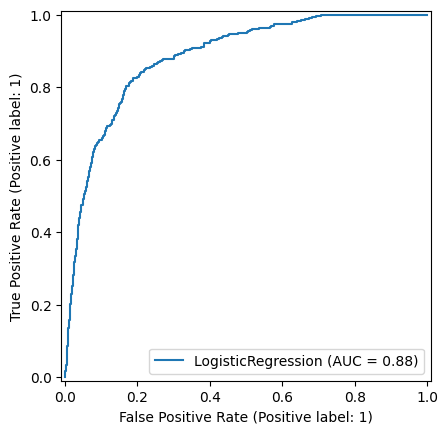

In [46]:

bank_labels_predicted = model.predict(bank_features_test)
print(classification_report(bank_labels_test, bank_labels_predicted))

baseline_score = f1_score(bank_labels_predicted, bank_labels_test)
print(baseline_score)

RocCurveDisplay.from_estimator(model, bank_features_train, bank_labels_train)

In [39]:
assert_less(baseline_score, 0.7)

### 7. Tune your model (2 points)
Fine-tune the `C` and `max_iter` parameters.

Use full grid search with the following values:
* `C`: 0.0001, 0.01, 0.1, 1, 10, 100, 10000
* `max_iter`: 50, 100, 300, 1000
* `fit_itercept`: True, False

Save the grid search result in the `grid_search` variable. Don't forget to use the better scoring model that you obtained in the previous task.

In [40]:
grid_search = GridSearchCV(
    estimator=LogisticRegression(),
    param_grid={
     "C": [0.0001, 0.01, 0.1, 1, 10, 100, 10000],
     "max_iter": [50, 100, 300, 1000],   
     "fit_intercept": [True, False]
    }
)
grid_search.fit(bank_features_test, bank_labels_test)

c:\Boyko Boev\SoftUni-Machine-Learning-September-2022\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Boyko Boev\SoftUni-Machine-Learning-September-2022\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-le

GridSearchCV(estimator=LogisticRegression(),
             param_grid={'C': [0.0001, 0.01, 0.1, 1, 10, 100, 10000],
                         'fit_intercept': [True, False],
                         'max_iter': [50, 100, 300, 1000]})

In [41]:
assert_is_not_none(grid_search)
assert_is_not_none(grid_search.best_estimator_)

### 8. Compare scores (1 point)
Use the best estimator from your grid search. Score it using the function from problem 6. Save your answer in `tuned_score`.

In [43]:
print(
    # grid_search.best_estimator_.score(),
    grid_search.best_estimator_,
    grid_search.best_estimator_.fit_intercept,
    grid_search.best_estimator_.max_iter,
)

tuned_predictions = grid_search.predict(bank_features_test)
tuned_score = f1_score(tuned_predictions, bank_labels_test)

LogisticRegression(C=100, fit_intercept=False, max_iter=1000) False 1000


In [44]:
print(tuned_score)

0.3394495412844037


In [45]:
print(baseline_score - tuned_score)

-0.02812878656742257


Hmmmm, it seems we have not obtained a better algorithm, even the opposite (the difference is marginal and depends on the random initialization of the cross-validation datasets).

We can, of course, do a lot more things to improve our model's performance, such as normalizing the data, feature selection and feature engineering, trying out different aspects, e.g. polynomial terms, RANSAC; even boosting (we'll talk about this later). However, we'll stop at this point.

What can we conclude? It seems that this is close to the best performance we can get out of this algorithm, given these data points.

We can try improving (cleaning) our dataset, selecting features, etc. but we most likely need a better algorithm. In the next labs, we're going to explore that.